In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv
/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv


In [2]:
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import re # for regular expressions
import pandas as pd 
pd.set_option("display.max_colwidth", 200) 
import string
import nltk # for text manipulation
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm import tqdm
import gensim
from sklearn.linear_model import LogisticRegression
from scipy import stats 
from sklearn import metrics 
from sklearn.metrics import mean_squared_error,mean_absolute_error, make_scorer,classification_report,confusion_matrix,accuracy_score,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import warnings 
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
df = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv')

In [4]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [6]:
df.shape

(41157, 6)

In [7]:
df.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

In [8]:
df.TweetAt.value_counts()

20-03-2020    3448
19-03-2020    3215
25-03-2020    2979
18-03-2020    2742
21-03-2020    2653
22-03-2020    2114
23-03-2020    2062
17-03-2020    1977
08-04-2020    1881
07-04-2020    1843
06-04-2020    1742
24-03-2020    1480
09-04-2020    1471
13-04-2020    1428
26-03-2020    1277
05-04-2020    1131
10-04-2020    1005
02-04-2020     954
11-04-2020     909
03-04-2020     810
12-04-2020     803
04-04-2020     767
16-03-2020     656
01-04-2020     630
27-03-2020     345
31-03-2020     316
14-04-2020     284
29-03-2020     125
30-03-2020      87
28-03-2020      23
Name: TweetAt, dtype: int64

In [9]:
df['Location'].value_counts()

London                     540
United States              528
London, England            520
New York, NY               395
Washington, DC             373
                          ... 
instagram: artrialclark      1
#WorldNews #Real411Now       1
Jupiter                      1
rabbit hole in KY            1
Rather nomadic!              1
Name: Location, Length: 12220, dtype: int64

In [10]:
df['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [11]:
missing_values = pd.DataFrame()
missing_values['column'] = df.columns

missing_values['percent'] = [round(100* df[col].isnull().sum() / len(df), 2) for col in df.columns]
missing_values = missing_values.sort_values('percent')
missing_values = missing_values[missing_values['percent']>0]

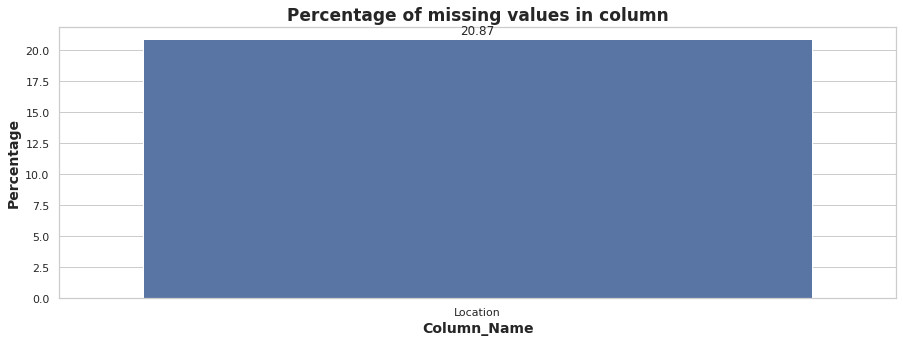

In [12]:
plt.figure(figsize=(15, 5))
sns.set(style='whitegrid', color_codes=True)
splot=sns.barplot(x='column', y='percent', data=missing_values)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.xlabel("Column_Name", size=14, weight="bold")
plt.ylabel("Percentage", size=14, weight="bold")
plt.title("Percentage of missing values in column",fontweight="bold",size=17)
plt.show()

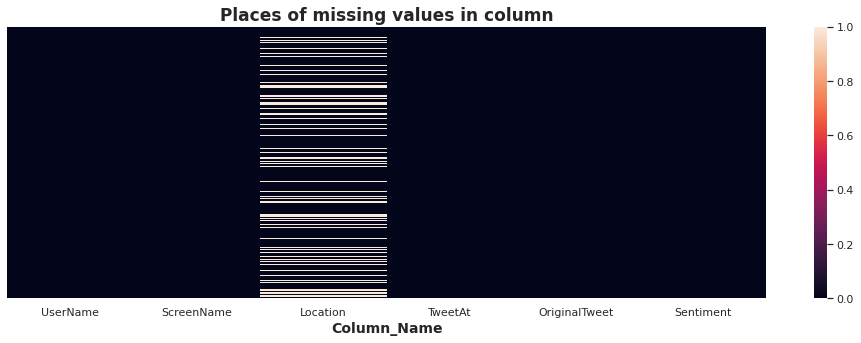

In [13]:
plt.figure(figsize=(17, 5))
sns.heatmap(df.isnull(), cbar=True, yticklabels=False)
plt.xlabel("Column_Name", size=14, weight="bold")
plt.title("Places of missing values in column",fontweight="bold",size=17)
plt.show()

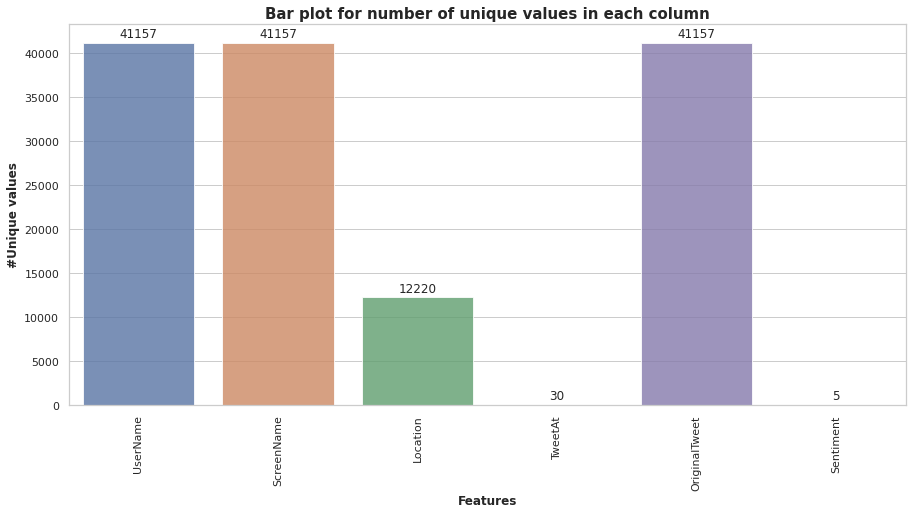

In [14]:
unique_df = pd.DataFrame()
unique_df['Features'] = df.columns
unique=[]
for i in df.columns:
    unique.append(df[i].nunique())
unique_df['Uniques'] = unique

f, ax = plt.subplots(1,1, figsize=(15,7))

splot = sns.barplot(x=unique_df['Features'], y=unique_df['Uniques'], alpha=0.8)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title('Bar plot for number of unique values in each column',weight='bold', size=15)
plt.ylabel('#Unique values', size=12, weight='bold')
plt.xlabel('Features', size=12, weight='bold')
plt.xticks(rotation=90)
plt.show()

In [15]:
loc_analysis = pd.DataFrame(df['Location'].value_counts().sort_values(ascending=False))
loc_analysis = loc_analysis.rename(columns={'Location':'count'})

In [16]:
import plotly.graph_objects as go

In [17]:
data = {
   "values": loc_analysis['count'][:15],
   "labels": loc_analysis.index[:15],
   "domain": {"column": 0},
   "name": "Location Name",
   "hoverinfo":"label+percent+name",
   "hole": .4,
   "type": "pie"
}
layout = go.Layout(title="<b>Ratio on Location</b>", legend=dict(x=0.1, y=1.1, orientation="h"))

data = [data]
fig = go.Figure(data = data, layout = layout)
fig.update_layout(title_x=0.5)
fig.show()

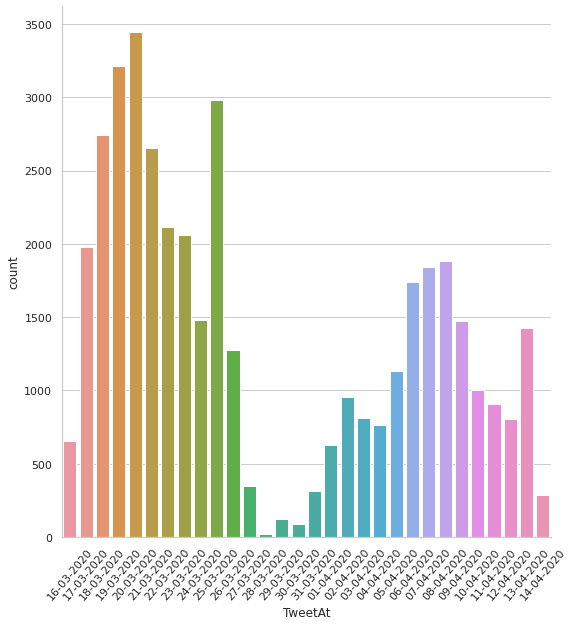

In [18]:
g=sns.catplot("TweetAt", data=df, kind="count", height=8)
g.set_xticklabels(rotation=50)

In [19]:
Top_Location_Of_tweet= df['Location'].value_counts().head(10)

sns.set(rc={'figure.figsize':(12,8)})
sns.set_style('white')

In [20]:
Top_Location_Of_tweet.head(10)

London             540
United States      528
London, England    520
New York, NY       395
Washington, DC     373
United Kingdom     337
Los Angeles, CA    281
India              268
UK                 232
Australia          225
Name: Location, dtype: int64

In [21]:

Top_Location_Of_tweet_df=pd.DataFrame(Top_Location_Of_tweet)
Top_Location_Of_tweet_df.reset_index(inplace=True)
Top_Location_Of_tweet_df.rename(columns={'index':'Location', 'Location':'Location_Count'}, inplace=True)
Top_Location_Of_tweet_df

,Location,Location_Count
0,London,540
1,United States,528
2,"London, England",520
3,"New York, NY",395
4,"Washington, DC",373
5,United Kingdom,337
6,"Los Angeles, CA",281
7,India,268
8,UK,232
9,Australia,225


[Text(0, 0, 'London'),
 Text(1, 0, 'United States'),
 Text(2, 0, 'London, England'),
 Text(3, 0, 'New York, NY'),
 Text(4, 0, 'Washington, DC'),
 Text(5, 0, 'United Kingdom'),
 Text(6, 0, 'Los Angeles, CA'),
 Text(7, 0, 'India'),
 Text(8, 0, 'UK'),
 Text(9, 0, 'Australia')]

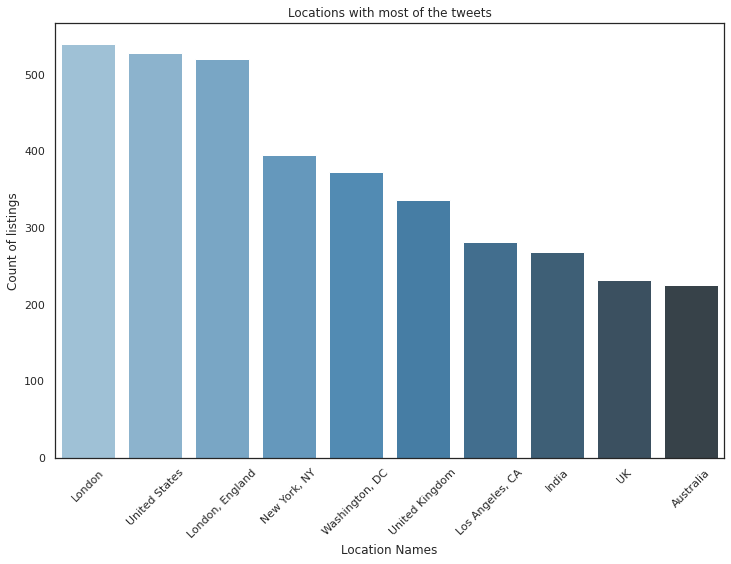

In [22]:
viz_1=sns.barplot(x="Location", y="Location_Count", data=Top_Location_Of_tweet_df,
                 palette='Blues_d')
viz_1.set_title('Locations with most of the tweets')
viz_1.set_ylabel('Count of listings')
viz_1.set_xlabel('Location Names')
viz_1.set_xticklabels(viz_1.get_xticklabels(), rotation=45)

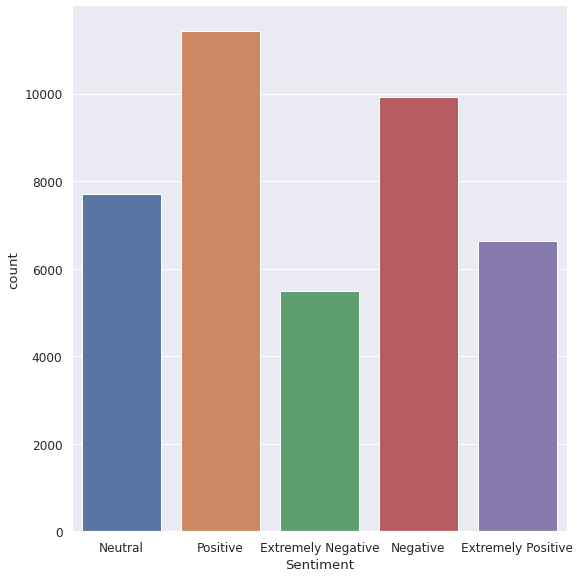

In [23]:
sns.set(font_scale=1.1)
sns.catplot("Sentiment", data=df, kind="count", height=8)

# Data Preprocessing
### A) Removing @user

In [24]:
# write function for removing @user
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    return input_txt

In [25]:
# create new column with removed @user
df['Tweet'] = np.vectorize(remove_pattern)(df['OriginalTweet'], '@[\w]*')

In [26]:
df.head(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P"
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\..."


### B) REMOVED HTTP AND URLS FROM TWEET

In [27]:
import re
df['Tweet'] = df['Tweet'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

In [28]:
df.head(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak"


### C) Removing Punctuations, Numbers, and Special Characters

In [29]:
# remove special characters, numbers, punctuations
df['Tweet'] = df['Tweet'].str.replace('[^a-zA-Z#]+',' ')

In [30]:
df.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,Coronavirus Australia Woolworths to give elderly disabled dedicated shopping hours amid COVID outbreak
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive,My food stock is not the only one which is empty PLEASE don t panic THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need Stay calm stay safe #COVID france #COVID #COVID #co...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative,Me ready to go at supermarket during the #COVID outbreak Not because I m paranoid but because my food stock is litteraly empty The #coronavirus is a serious thing but please don t panic It causes ...


### D) Removing Short Words

In [31]:
# remove short words
df['Tweet'] = df['Tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

In [32]:
df.head(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk your neighbours family exchange phone numbers create contact list with phone numbers neighbours schools employer chemist set online shopping accounts poss adequate supplies regular med...
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,Coronavirus Australia Woolworths give elderly disabled dedicated shopping hours amid COVID outbreak
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive,food stock not the only one which empty PLEASE don panic THERE WILL ENOUGH FOOD FOR EVERYONE you not take more than you need Stay calm stay safe #COVID france #COVID #COVID #coronavirus #confineme...


### E) Tokenization


In [33]:
# create new variable tokenized tweet 
tokenized_tweet = df['Tweet'].apply(lambda x: x.split())

In [34]:
df.head(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk your neighbours family exchange phone numbers create contact list with phone numbers neighbours schools employer chemist set online shopping accounts poss adequate supplies regular med...
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,Coronavirus Australia Woolworths give elderly disabled dedicated shopping hours amid COVID outbreak
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive,food stock not the only one which empty PLEASE don panic THERE WILL ENOUGH FOOD FOR EVERYONE you not take more than you need Stay calm stay safe #COVID france #COVID #COVID #coronavirus #confineme...


### F) Stemming

In [35]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

# apply stemmer for tokenized_tweet
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

In [36]:
df.head(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk your neighbours family exchange phone numbers create contact list with phone numbers neighbours schools employer chemist set online shopping accounts poss adequate supplies regular med...
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,Coronavirus Australia Woolworths give elderly disabled dedicated shopping hours amid COVID outbreak
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive,food stock not the only one which empty PLEASE don panic THERE WILL ENOUGH FOOD FOR EVERYONE you not take more than you need Stay calm stay safe #COVID france #COVID #COVID #coronavirus #confineme...


### G) tokenized_tweet

In [37]:
# join tokens into one sentence
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
# change df['Tweet'] to tokenized_tweet

In [38]:
df['Tweet']  = tokenized_tweet
df.head(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,coronaviru australia woolworth give elderli disabl dedic shop hour amid covid outbreak
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive,food stock not the onli one which empti pleas don panic there will enough food for everyon you not take more than you need stay calm stay safe #covid franc #covid #covid #coronaviru #confin #confi...


# Understanding the common words used in the tweets: WordCloud

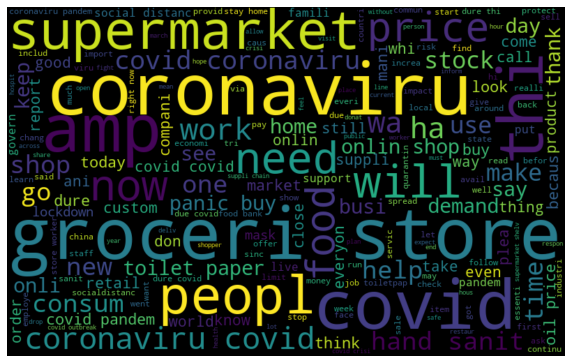

In [39]:
# create text from all tweets
all_words = ' '.join([text for text in df['Tweet']])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

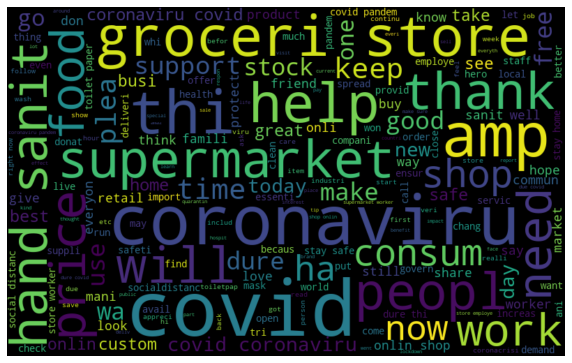

In [40]:
# create text from just normal tweets
normal_words = ' '.join([text for text in df['Tweet'][df['Sentiment'] == 'Extremely Positive']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

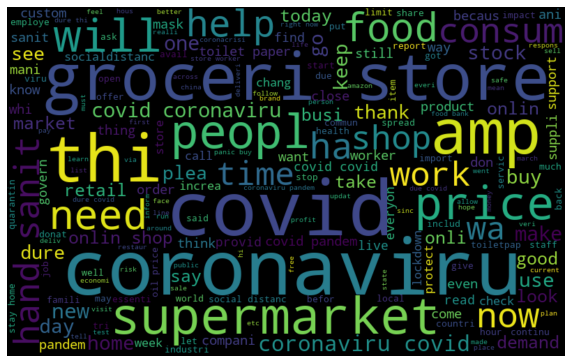

In [41]:
# create text from just normal tweets
normal_words = ' '.join([text for text in df['Tweet'][df['Sentiment'] == 'Positive']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

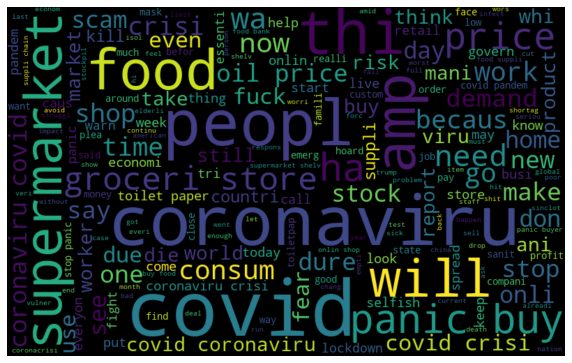

In [42]:
# create text from just normal tweets
normal_words = ' '.join([text for text in df['Tweet'][df['Sentiment'] == 'Extremely Negative']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

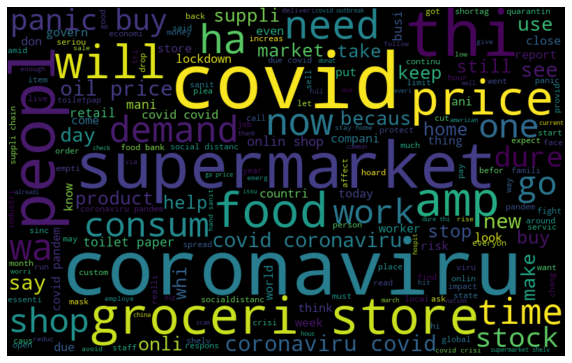

In [43]:
# create text from just normal tweets
normal_words = ' '.join([text for text in df['Tweet'][df['Sentiment'] == 'Negative']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

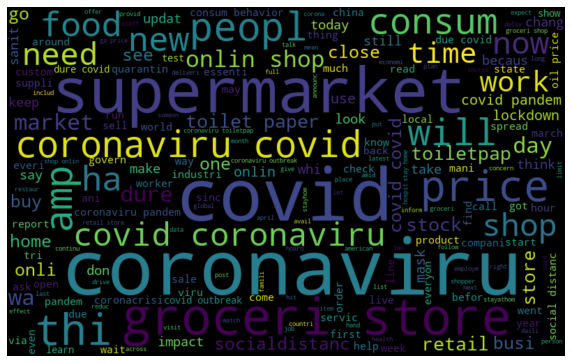

In [44]:
# create text from just normal tweets
normal_words = ' '.join([text for text in df['Tweet'][df['Sentiment'] == 'Neutral']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Understanding the impact of Hashtags on tweets sentiment

In [45]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    for i in x:
        ht = re.findall(r'#(\w+)', i)
        hashtags.append(ht)
    return hashtags

In [46]:
# extracting hashtags from non racist/sexist tweets
HT_Extremely_Positive = hashtag_extract(df['OriginalTweet'][df['Sentiment'] == 'Extremely Positive'])
HT_Positive = hashtag_extract(df['OriginalTweet'][df['Sentiment'] == 'Positive'])
HT_Neutral = hashtag_extract(df['OriginalTweet'][df['Sentiment'] == 'Neutral'])
HT_Negative = hashtag_extract(df['OriginalTweet'][df['Sentiment'] == 'Negative'])
HT_Extremely_Negative = hashtag_extract(df['OriginalTweet'][df['Sentiment'] == 'Extremely Negative'])



# unnesting list
HT_Extremely_Positive = sum(HT_Extremely_Positive, [])
HT_Positive = sum(HT_Positive, [])
HT_Neutral = sum(HT_Neutral, [])
HT_Negative = sum(HT_Negative,[])
HT_Extremely_Negative = sum(HT_Extremely_Negative,[])

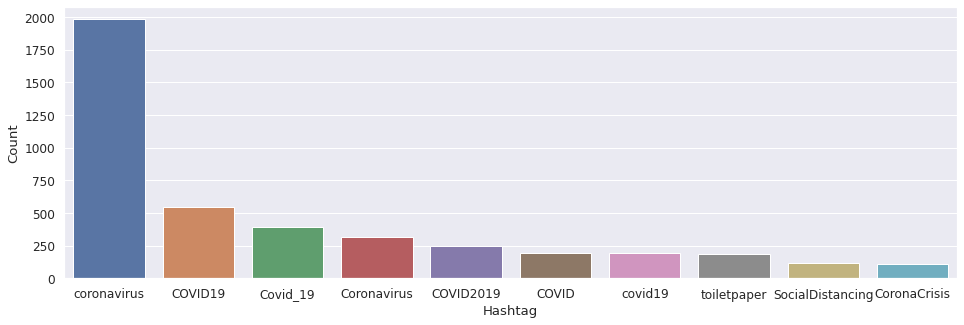

In [47]:
# making frequency distribution top 10 Extremely Positive hashtags
a = nltk.FreqDist(HT_Extremely_Positive)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count' : list(a.values())})

d = d.nlargest(columns = 'Count', n = 10)

plt.figure(figsize = (16,5))
ax = sns.barplot(data =d, x = 'Hashtag', y = 'Count')
plt.show()

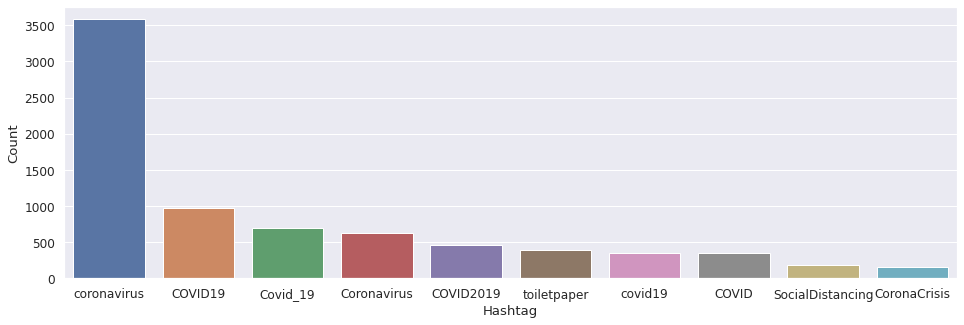

In [48]:
# making frequency distribution top 10 Positive hashtags
a = nltk.FreqDist(HT_Positive)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count' : list(a.values())})

d = d.nlargest(columns = 'Count', n = 10)

plt.figure(figsize = (16,5))
ax = sns.barplot(data =d, x = 'Hashtag', y = 'Count')
plt.show()

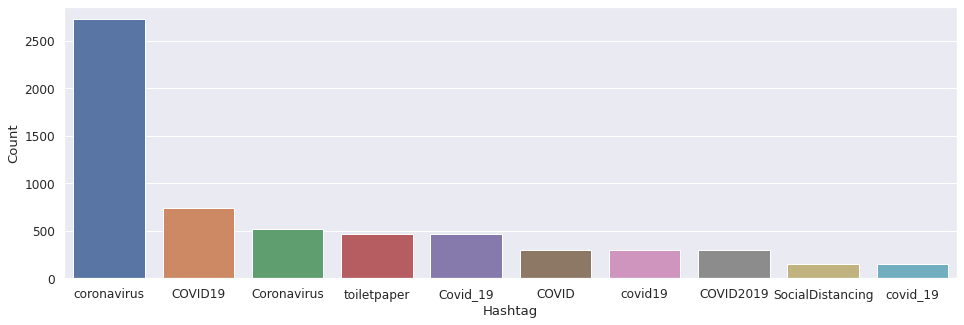

In [49]:
# making frequency distribution top 10 Neutral hashtags
a = nltk.FreqDist(HT_Neutral)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count' : list(a.values())})

d = d.nlargest(columns = 'Count', n = 10)

plt.figure(figsize = (16,5))
ax = sns.barplot(data =d, x = 'Hashtag', y = 'Count')
plt.show()

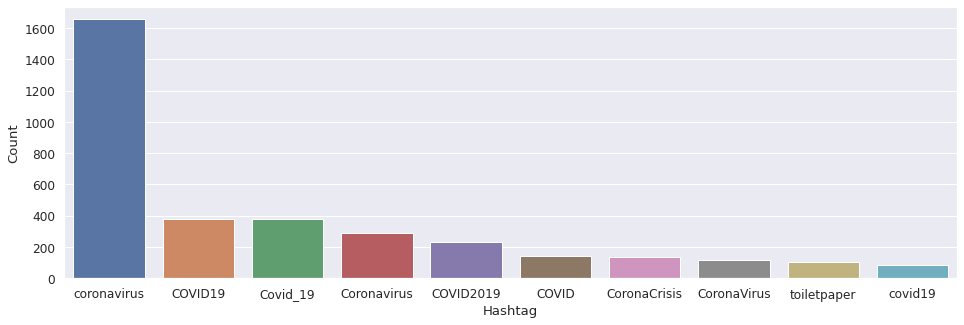

In [50]:
# making frequency distribution top 10 Extremely Negative hashtags
a = nltk.FreqDist(HT_Extremely_Negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count' : list(a.values())})

d = d.nlargest(columns = 'Count', n = 10)

plt.figure(figsize = (16,5))
ax = sns.barplot(data =d, x = 'Hashtag', y = 'Count')
plt.show()

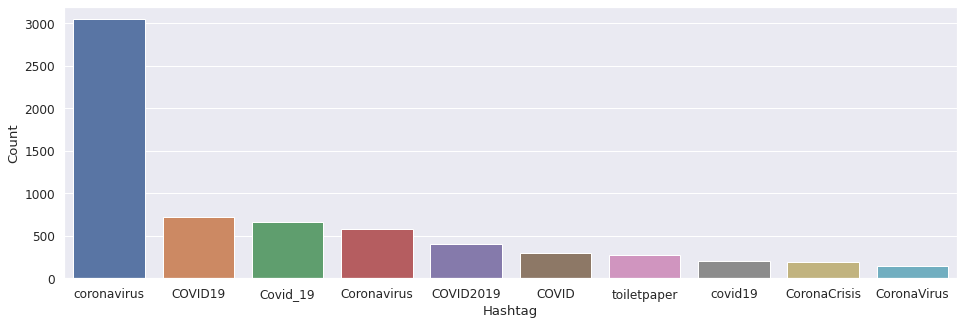

In [51]:
# making frequency distribution top 10 Negative hashtags
a = nltk.FreqDist(HT_Negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count' : list(a.values())})

d = d.nlargest(columns = 'Count', n = 10)

plt.figure(figsize = (16,5))
ax = sns.barplot(data =d, x = 'Hashtag', y = 'Count')
plt.show()

#  Extracting Features from Cleaned Tweets

In [52]:
new_df = df[['Tweet','Sentiment']]
new_df.head()

,Tweet,Sentiment
0,,Neutral
1,advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order,Positive
2,coronaviru australia woolworth give elderli disabl dedic shop hour amid covid outbreak,Positive
3,food stock not the onli one which empti pleas don panic there will enough food for everyon you not take more than you need stay calm stay safe #covid franc #covid #covid #coronaviru #confin #confi...,Positive
4,readi supermarket dure the #covid outbreak not becaus paranoid but becaus food stock litterali empti the #coronaviru seriou thing but pleas don panic caus shortag #coronavirusfr #restezchezv #stay...,Extremely Negative


In [53]:
df['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

### Converting into lower case

In [54]:
new_df["Tweet"] = new_df["Tweet"].str.lower()#.str.split()

In [55]:
new_df.head()

,Tweet,Sentiment
0,,Neutral
1,advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order,Positive
2,coronaviru australia woolworth give elderli disabl dedic shop hour amid covid outbreak,Positive
3,food stock not the onli one which empti pleas don panic there will enough food for everyon you not take more than you need stay calm stay safe #covid franc #covid #covid #coronaviru #confin #confi...,Positive
4,readi supermarket dure the #covid outbreak not becaus paranoid but becaus food stock litterali empti the #coronaviru seriou thing but pleas don panic caus shortag #coronavirusfr #restezchezv #stay...,Extremely Negative


### Removing StopWords

In [56]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [57]:
new_df['Tweet'].apply(lambda x: [item for item in x if item not in stop])

0                                                                                                                                                                                                             []
1        [v, c,  , l, k,  , u, r,  , n, e, g, h, b, u, r,  , f, l,  , e, x, c, h, n, g,  , p, h, n, e,  , n, u, b, e, r,  , c, r, e,  , c, n, c,  , l,  , w, h,  , p, h, n, e,  , n, u, b, e, r,  , n, e, g, ...
2                                                            [c, r, n, v, r, u,  , u, r, l,  , w, l, w, r, h,  , g, v, e,  , e, l, e, r, l,  , b, l,  , e, c,  , h, p,  , h, u, r,  ,  , c, v,  , u, b, r, e, k]
3        [f,  , c, k,  , n,  , h, e,  , n, l,  , n, e,  , w, h, c, h,  , e, p,  , p, l, e,  , n,  , p, n, c,  , h, e, r, e,  , w, l, l,  , e, n, u, g, h,  , f,  , f, r,  , e, v, e, r, n,  , u,  , n,  , k, ...
4        [r, e,  , u, p, e, r, r, k, e,  , u, r, e,  , h, e,  , #, c, v,  , u, b, r, e, k,  , n,  , b, e, c, u,  , p, r, n,  , b, u,  , b, e, c, u,  , f,  , c, k,  

In [58]:
new_df.isnull().sum()

Tweet        0
Sentiment    0
dtype: int64

# Spitting Our Dataset into Training And Testing Dataset ( For Multiclass Classification)

In [59]:
from sklearn.model_selection import train_test_split

train,valid = train_test_split(new_df,test_size = 0.2,random_state=0,stratify = new_df.Sentiment.values) #stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset.
print("train shape : ", train.shape)
print("valid shape : ", valid.shape)

train shape :  (32925, 2)
valid shape :  (8232, 2)


# Use Of Counter Vectorizer For Multi Class Classification

In [60]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

X_train = vectorizer.fit_transform(train.Tweet.values)
X_valid = vectorizer.transform(valid.Tweet.values)

y_train = train.Sentiment.values
y_valid = valid.Sentiment.values

print("X_train.shape : ", X_train.shape)
print("X_train.shape : ", X_valid.shape)
print("y_train.shape : ", y_train.shape)
print("y_valid.shape : ", y_valid.shape)

X_train.shape :  (32925, 27089)
X_train.shape :  (8232, 27089)
y_train.shape :  (32925,)
y_valid.shape :  (8232,)


# Naive Bayes Classifier for MULTICLASS Classification

In [61]:
from sklearn.naive_bayes import MultinomialNB

naiveByes_clf = MultinomialNB()

naiveByes_clf.fit(X_train,y_train)

NB_prediction = naiveByes_clf.predict(X_valid)
NB_accuracy = accuracy_score(y_valid,NB_prediction)
print("training accuracy Score    : ",naiveByes_clf.score(X_train,y_train))
print("Validation accuracy Score : ",NB_accuracy )
print(classification_report(NB_prediction,y_valid))

training accuracy Score    :  0.6931511009870919
Validation accuracy Score :  0.47947035957240036
                    precision    recall  f1-score   support

Extremely Negative       0.39      0.59      0.47       736
Extremely Positive       0.40      0.58      0.47       907
          Negative       0.52      0.43      0.47      2398
           Neutral       0.34      0.67      0.45       786
          Positive       0.62      0.42      0.50      3405

          accuracy                           0.48      8232
         macro avg       0.46      0.54      0.47      8232
      weighted avg       0.52      0.48      0.48      8232



# Stochastic Gradient Descent-SGD Classifier( MULTICLASS CLASSIFICATION)

In [62]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss = 'hinge', penalty = 'l2', random_state=0)

sgd_clf.fit(X_train,y_train)

sgd_prediction = sgd_clf.predict(X_valid)
sgd_accuracy = accuracy_score(y_valid,sgd_prediction)
print("Training accuracy Score    : ",sgd_clf.score(X_train,y_train))
print("Validation accuracy Score : ",sgd_accuracy )
print(classification_report(sgd_prediction,y_valid))

Training accuracy Score    :  0.8288838268792711
Validation accuracy Score :  0.5726433430515063
                    precision    recall  f1-score   support

Extremely Negative       0.68      0.62      0.65      1210
Extremely Positive       0.68      0.65      0.67      1396
          Negative       0.45      0.50      0.48      1785
           Neutral       0.75      0.59      0.66      1963
          Positive       0.44      0.54      0.48      1878

          accuracy                           0.57      8232
         macro avg       0.60      0.58      0.59      8232
      weighted avg       0.59      0.57      0.58      8232



# RANDOM FOREST CLASSIFIER 

In [63]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

rf_clf.fit(X_train,y_train)

rf_prediction = rf_clf.predict(X_valid)
rf_accuracy = accuracy_score(y_valid,rf_prediction)
print("Training accuracy Score    : ",rf_clf.score(X_train,y_train))
print("Validation accuracy Score : ",rf_accuracy )
print(classification_report(rf_prediction,y_valid))

Training accuracy Score    :  0.9958997722095672
Validation accuracy Score :  0.5590379008746356
                    precision    recall  f1-score   support

Extremely Negative       0.38      0.70      0.49       596
Extremely Positive       0.35      0.72      0.47       650
          Negative       0.54      0.51      0.53      2085
           Neutral       0.76      0.60      0.67      1955
          Positive       0.65      0.50      0.56      2946

          accuracy                           0.56      8232
         macro avg       0.54      0.61      0.55      8232
      weighted avg       0.60      0.56      0.57      8232



# Extreme Gradient Boosting

In [64]:
#takes huge amount of time to execute
import xgboost as xgb

xgboost_clf = xgb.XGBClassifier()

xgboost_clf.fit(X_train, y_train)

xgb_prediction = xgboost_clf.predict(X_valid)
xgb_accuracy = accuracy_score(y_valid,xgb_prediction)
print("Training accuracy Score    : ",xgboost_clf.score(X_train,y_train))
print("Validation accuracy Score : ",xgb_accuracy )
print(classification_report(xgb_prediction,y_valid))

[06:56:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training accuracy Score    :  0.70958238420653
Validation accuracy Score :  0.592201166180758
                    precision    recall  f1-score   support

Extremely Negative       0.51      0.66      0.57       853
Extremely Positive       0.54      0.72      0.62       993
          Negative       0.49      0.57      0.53      1685
           Neutral       0.80      0.57      0.66      2171
          Positive       0.61      0.55      0.58      2530

          accuracy                           0.59      8232
         macro avg       0.59      0.61      0.59      8232
      weighted avg       0.62      0.59      0.60      8232



# Support vector machine

In [65]:
from sklearn.svm import SVC

svc = SVC()

svc.fit(X_train, y_train)

svc_prediction = svc.predict(X_valid)
svc_accuracy = accuracy_score(y_valid,svc_prediction)
print("Training accuracy Score    : ",svc.score(X_train,y_train))
print("Validation accuracy Score : ",svc_accuracy )
print(classification_report(svc_prediction,y_valid))

Training accuracy Score    :  0.8993773728170084
Validation accuracy Score :  0.6072643343051506
                    precision    recall  f1-score   support

Extremely Negative       0.48      0.71      0.57       738
Extremely Positive       0.53      0.78      0.63       902
          Negative       0.58      0.55      0.56      2082
           Neutral       0.71      0.64      0.67      1718
          Positive       0.67      0.55      0.61      2792

          accuracy                           0.61      8232
         macro avg       0.59      0.65      0.61      8232
      weighted avg       0.62      0.61      0.61      8232



# Logistic Regression

In [66]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

logreg_prediction = logreg.predict(X_valid)
logreg_accuracy = accuracy_score(y_valid,logreg_prediction)
print("Training accuracy Score    : ",logreg.score(X_train,y_train))
print("Validation accuracy Score : ",logreg_accuracy )
print(classification_report(logreg_prediction,y_valid))

Training accuracy Score    :  0.8860744115413819
Validation accuracy Score :  0.6179543245869776
                    precision    recall  f1-score   support

Extremely Negative       0.62      0.68      0.65       999
Extremely Positive       0.62      0.71      0.66      1147
          Negative       0.54      0.56      0.55      1896
           Neutral       0.72      0.64      0.68      1744
          Positive       0.62      0.58      0.59      2446

          accuracy                           0.62      8232
         macro avg       0.62      0.63      0.63      8232
      weighted avg       0.62      0.62      0.62      8232



# All the multiclass models test accuracy in descending order

In [67]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'XGBoost',],
    'Test accuracy': [svc_accuracy, logreg_accuracy, 
              rf_accuracy, NB_accuracy, 
              sgd_accuracy, xgb_accuracy]})

models.sort_values(by='Test accuracy', ascending=False)

,Model,Test accuracy
1,Logistic Regression,0.617954
0,Support Vector Machines,0.607264
5,XGBoost,0.592201
4,Stochastic Gradient Decent,0.572643
2,Random Forest,0.559038
3,Naive Bayes,0.479470


# CONVRTING OUR MULTICLASS CLASSIFICATION INTO BINARY CLASSIFICATION

In [68]:
CATBOOST = new_df[['Tweet','Sentiment']]

In [69]:
CATBOOST["Sentiment"]= CATBOOST["Sentiment"].replace('Positive',1) 
CATBOOST["Sentiment"]= CATBOOST["Sentiment"].replace('Extremely Positive',1) 
CATBOOST["Sentiment"]= CATBOOST["Sentiment"].replace('Neutral',1) 
CATBOOST["Sentiment"]= CATBOOST["Sentiment"].replace('Negative',0) 
CATBOOST["Sentiment"]= CATBOOST["Sentiment"].replace('Extremely Negative',0)

In [70]:
CATBOOST.head(5)

,Tweet,Sentiment
0,,1
1,advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order,1
2,coronaviru australia woolworth give elderli disabl dedic shop hour amid covid outbreak,1
3,food stock not the onli one which empti pleas don panic there will enough food for everyon you not take more than you need stay calm stay safe #covid franc #covid #covid #coronaviru #confin #confi...,1
4,readi supermarket dure the #covid outbreak not becaus paranoid but becaus food stock litterali empti the #coronaviru seriou thing but pleas don panic caus shortag #coronavirusfr #restezchezv #stay...,0


In [71]:
CATBOOST['Sentiment'].value_counts()

1    25759
0    15398
Name: Sentiment, dtype: int64

# DIVIDING OUR DATASET INTO TRAINING AND TESTING

In [72]:
from sklearn.model_selection import train_test_split

train,valid = train_test_split(CATBOOST,test_size = 0.2,random_state=0,stratify = CATBOOST.Sentiment.values) #stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset.
print("train shape : ", train.shape)
print("valid shape : ", valid.shape)

train shape :  (32925, 2)
valid shape :  (8232, 2)


# USING COUNT VECTORIZER

In [73]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

X_train = vectorizer.fit_transform(train.Tweet.values)
X_valid = vectorizer.transform(valid.Tweet.values)

y_train = train.Sentiment.values
y_valid = valid.Sentiment.values

print("X_train.shape : ", X_train.shape)
print("X_train.shape : ", X_valid.shape)
print("y_train.shape : ", y_train.shape)
print("y_valid.shape : ", y_valid.shape)

X_train.shape :  (32925, 27205)
X_train.shape :  (8232, 27205)
y_train.shape :  (32925,)
y_valid.shape :  (8232,)


# NAIVE BAYES CLASSIFIER FOR BINARY CLASSIFICATION.

In [74]:
from sklearn.naive_bayes import MultinomialNB

naiveByes_clf = MultinomialNB()

naiveByes_clf.fit(X_train,y_train)

NB_prediction = naiveByes_clf.predict(X_valid)
NB_accuracy = accuracy_score(y_valid,NB_prediction)
print("training accuracy Score    : ",naiveByes_clf.score(X_train,y_train))
print("Validation accuracy Score : ",NB_accuracy )
print(classification_report(NB_prediction,y_valid))

training accuracy Score    :  0.8585573272589218
Validation accuracy Score :  0.7916666666666666
              precision    recall  f1-score   support

           0       0.69      0.74      0.71      2899
           1       0.85      0.82      0.84      5333

    accuracy                           0.79      8232
   macro avg       0.77      0.78      0.77      8232
weighted avg       0.80      0.79      0.79      8232



# RANDOM FOREST CLASSIFIER FOR BINARY CLASSIFICATION

In [75]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

rf_clf.fit(X_train,y_train)

rf_prediction = rf_clf.predict(X_valid)
rf_accuracy = accuracy_score(y_valid,rf_prediction)
print("Training accuracy Score    : ",rf_clf.score(X_train,y_train))
print("Validation accuracy Score : ",rf_accuracy )
print(classification_report(rf_prediction,y_valid))

Training accuracy Score    :  0.9985725132877753
Validation accuracy Score :  0.83078231292517
              precision    recall  f1-score   support

           0       0.71      0.82      0.76      2659
           1       0.91      0.84      0.87      5573

    accuracy                           0.83      8232
   macro avg       0.81      0.83      0.81      8232
weighted avg       0.84      0.83      0.83      8232



# LOGISTIC REGRESSION FOR BINARY CLASSIFICATION

In [76]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

logreg_prediction = logreg.predict(X_valid)
logreg_accuracy = accuracy_score(y_valid,logreg_prediction)
print("Training accuracy Score    : ",logreg.score(X_train,y_train))
print("Validation accuracy Score : ",logreg_accuracy )
print(classification_report(logreg_prediction,y_valid))

Training accuracy Score    :  0.937798025816249
Validation accuracy Score :  0.8594509232264335
              precision    recall  f1-score   support

           0       0.77      0.84      0.80      2791
           1       0.92      0.87      0.89      5441

    accuracy                           0.86      8232
   macro avg       0.84      0.86      0.85      8232
weighted avg       0.86      0.86      0.86      8232



# XG BOOST( BINARY CLASSIFICATION)

In [77]:
import xgboost as xgb

xgboost_clf = xgb.XGBClassifier()

xgboost_clf.fit(X_train, y_train)

xgb_prediction = xgboost_clf.predict(X_valid)
xgb_accuracy = accuracy_score(y_valid,xgb_prediction)
print("Training accuracy Score    : ",xgboost_clf.score(X_train,y_train))
print("Validation accuracy Score : ",xgb_accuracy )
print(classification_report(xgb_prediction,y_valid))

[07:13:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training accuracy Score    :  0.8509946848899013
Validation accuracy Score :  0.8219144800777454
              precision    recall  f1-score   support

           0       0.65      0.84      0.73      2360
           1       0.93      0.81      0.87      5872

    accuracy                           0.82      8232
   macro avg       0.79      0.83      0.80      8232
weighted avg       0.85      0.82      0.83      8232



# SUPPORT VECTOR MACHINE(BINARY CLASSIFICATION)

In [78]:
from sklearn.svm import SVC

svc = SVC()

svc.fit(X_train, y_train)

svc_prediction = svc.predict(X_valid)
svc_accuracy = accuracy_score(y_valid,svc_prediction)
print("Training accuracy Score    : ",svc.score(X_train,y_train))
print("Validation accuracy Score : ",svc_accuracy )
print(classification_report(svc_prediction,y_valid))

Training accuracy Score    :  0.9569020501138952
Validation accuracy Score :  0.8456025267249757
              precision    recall  f1-score   support

           0       0.69      0.87      0.77      2467
           1       0.94      0.84      0.88      5765

    accuracy                           0.85      8232
   macro avg       0.82      0.85      0.83      8232
weighted avg       0.86      0.85      0.85      8232



# Stochastic Gradient Descent-SGD Classifier( BINARY CLASSIFICATION)

In [79]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss = 'hinge', penalty = 'l2', random_state=0)

sgd_clf.fit(X_train,y_train)

sgd_prediction = sgd_clf.predict(X_valid)
sgd_accuracy = accuracy_score(y_valid,sgd_prediction)
print("Training accuracy Score    : ",sgd_clf.score(X_train,y_train))
print("Validation accuracy Score : ",sgd_accuracy )
print(classification_report(sgd_prediction,y_valid))

Training accuracy Score    :  0.9350949126803341
Validation accuracy Score :  0.8624878522837707
              precision    recall  f1-score   support

           0       0.78      0.84      0.81      2882
           1       0.91      0.88      0.89      5350

    accuracy                           0.86      8232
   macro avg       0.85      0.86      0.85      8232
weighted avg       0.87      0.86      0.86      8232



# EVALUATION OF ALL BINARY CLASSIFICATION MODELS

In [80]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'XGBoost'],
    'Test accuracy': [svc_accuracy, logreg_accuracy, 
              rf_accuracy, NB_accuracy, 
              sgd_accuracy, xgb_accuracy]})

models.sort_values(by='Test accuracy', ascending=False)

,Model,Test accuracy
4,Stochastic Gradient Decent,0.862488
1,Logistic Regression,0.859451
0,Support Vector Machines,0.845603
2,Random Forest,0.830782
5,XGBoost,0.821914
3,Naive Bayes,0.791667


# Winner Model: Stochastic Gradient Descent-SGD Classifier

In [81]:
# Get the predicted classes
train_class_preds = sgd_clf.predict(X_train)
test_class_preds = sgd_clf.predict(X_valid)

[[10982  1336]
 [  801 19806]]


[Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')]

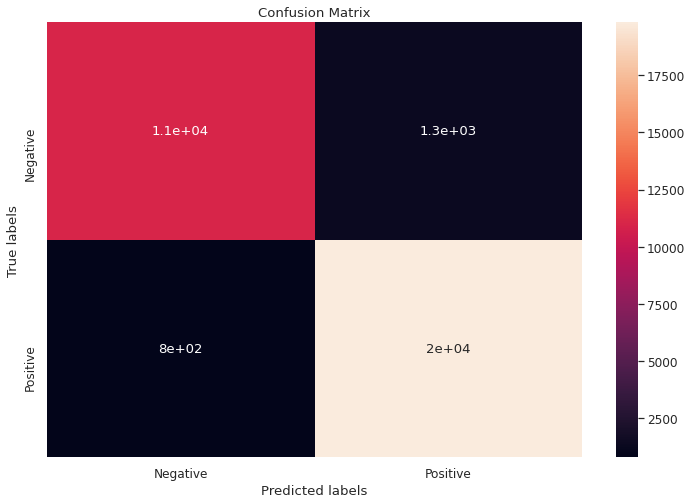

In [82]:
# Get the confusion matrix for both train and test. We are getting very low type and type 2 errors.

labels = ['Negative', 'Positive']
cm = confusion_matrix(y_train, train_class_preds)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [83]:
# Let's check the overall accuracy. Overall accuracy is very good.
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

y_pred = sgd_clf.predict(X_valid)

score =accuracy_score(y_valid,y_pred)
print('accuracy is', score)

accuracy is 0.8624878522837707


In [84]:
# F1 score for our classifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


y_pred =  sgd_clf.predict(X_valid)
print(f1_score(y_valid,y_pred, average="macro"))

0.851170918004085


In [85]:
#score is mean accuracy
scikit_score = sgd_clf.score(X_valid,y_valid)
print('scikit score:', scikit_score)

scikit score: 0.8624878522837707


In [86]:
# Recall score for our winner model
recall_score(y_valid, y_pred, average='macro')

0.8467232495765105

In [87]:
# Classification Report for our stochastic gradient descent algorithm
classification_report(y_valid,y_pred)

'              precision    recall  f1-score   support\n\n           0       0.84      0.78      0.81      3080\n           1       0.88      0.91      0.89      5152\n\n    accuracy                           0.86      8232\n   macro avg       0.86      0.85      0.85      8232\nweighted avg       0.86      0.86      0.86      8232\n'

In [88]:
# Very low type 1 and type 2 error
confusion_matrix(y_valid,y_pred)

array([[2415,  665],
       [ 467, 4685]])